The following cell ensures that the Python files in the `project_dir/code/` directory can be correctly imported by this notebook

In [41]:
import sys
import os
from pathlib import Path

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add the project's `code` directory to the Python path
notebooks_dir = os.getcwd()
project_dir = os.path.dirname(notebooks_dir)
code_dir = os.path.join(project_dir, 'code')  
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from my_utils import dict_from_disk, load_image_as_tensor
from cross_attention_dataset import CrossAttentionDataset
from dumb_experiment_probe import LinearProbe
from visualisation_utils import plot_masks_grid

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
# if torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
# elif torch.cuda.is_available():
#     DEVICE = torch.device("cuda")
# else:
DEVICE = torch.device("cpu")

### Load cross-attention maps from disk

In [3]:
# Set the path to the directory containing the cross-attention maps
FEATURE_DIR = Path("/Users/chrisoffner3d/Library/Mobile Documents/com~apple~CloudDocs/dl_feature_maps/ECSSD_resized/features")

# Filter files in directory for the cross-attention maps
cross_attn_filenames = sorted([f for f in FEATURE_DIR.glob("*.h5") if f.stem.endswith("_cross")])

# Load the cross-attention maps
cross_attn_maps = [dict_from_disk(str(f)) for f in tqdm(cross_attn_filenames)]

100%|██████████| 1000/1000 [00:05<00:00, 180.78it/s]


In [4]:
GT_DIR = Path("/Users/chrisoffner3d/Documents/Dev/ETH/DL Code/dl_project/DL Project/data/ECSSD_resized/gt")

# Load the ground truth masks for the cross-attention maps as (64, 64) tensors
base_names = map(lambda path: path.stem, cross_attn_filenames)
gt_paths = sorted([GT_DIR / f"{base_name.split('_')[0]}.png" for base_name in base_names])
gt_segmentations = [load_image_as_tensor(path, True) for path in gt_paths]

### Create a dataset and data loader from cross-attention maps

In [5]:
dataset = CrossAttentionDataset(cross_attn_maps, gt_segmentations)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

### Train model

In [6]:
model = LinearProbe(n_timesteps=len(dataset.timesteps)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
for epoch in range(10):
    with tqdm(data_loader, desc=f"Epoch {epoch}") as tepoch:
        for cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in tepoch:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).unsqueeze(0)
            loss = criterion(output, gt)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the progress bar description
            tepoch.set_description(f"Epoch {epoch} Loss: {loss.item():.4f}")

Epoch 9 Loss: 35.1493: 100%|██████████| 1000/1000 [00:06<00:00, 146.00it/s]


# Show the cross-attention maps

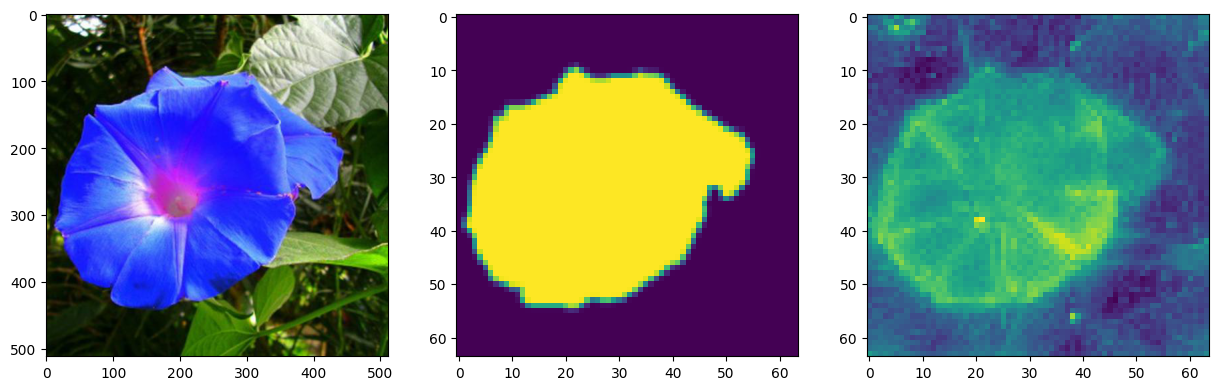

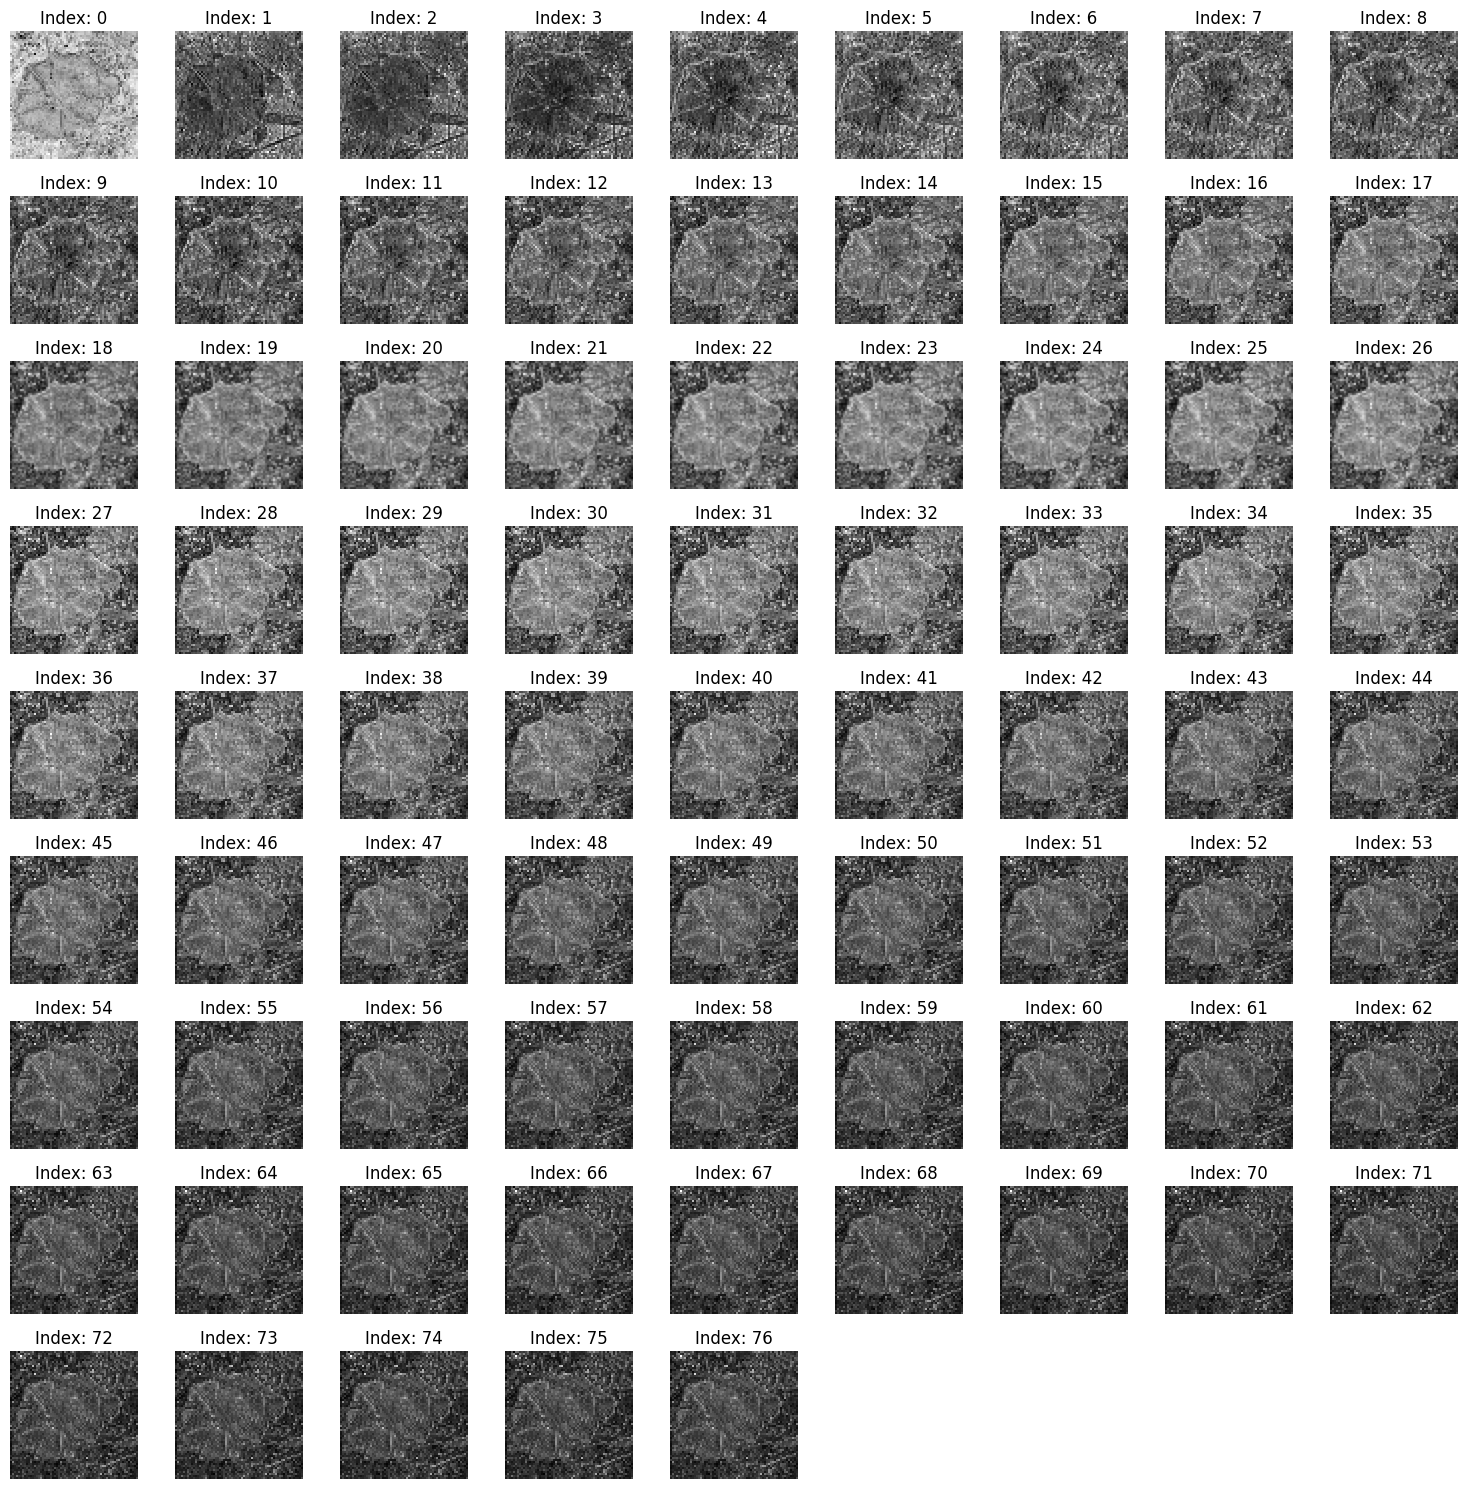

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
idx = 323

img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
gt = load_image_as_tensor(gt_paths[idx], True)

with torch.no_grad():
    cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, _ = dataset[idx]
    output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).squeeze().detach().cpu().numpy()

axs[0].imshow(img.permute(1, 2, 0))
axs[1].imshow(gt)
axs[2].imshow(output)

plot_masks_grid(cross_attn_64[0])